# 🧹 EMBER Data Preprocessing Pipeline

**Run this ONCE to clean and prepare data for both Graph GNN and ViT4Mal**

### What this does:
1. ✅ Loads raw EMBER JSONL files from Google Drive
2. ✅ Cleans data (removes NaN, outliers, unlabeled)
3. ✅ Balances classes (50/50 malware/benign)
4. ✅ Validates quality
5. ✅ Saves cleaned data back to Drive
6. ✅ Creates train/test splits

### Output files:
- `ember_train_cleaned.npz` - Clean training data
- `ember_test_cleaned.npz` - Clean test data
- `data_quality_report.json` - Quality metrics

**Time to run: ~10-15 minutes**  
**Run frequency: Once (or when you get new data)**

## 📦 Setup

In [1]:
# Install required packages (if not already installed)
!pip install numpy pandas scikit-learn tqdm -q

In [2]:
import json
import numpy as np
import pandas as pd
from pathlib import Path
from collections import Counter
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings('ignore')

print("✅ Imports successful!")

✅ Imports successful!


## 📁 Mount Google Drive

In [3]:
from google.colab import drive
drive.mount('/content/drive')

print("✅ Google Drive mounted!")

Mounted at /content/drive
✅ Google Drive mounted!


## ⚙️ Configuration

In [4]:
# 🔧 MODIFY THESE PATHS for your setup

# Where your raw EMBER JSONL files are
RAW_DATA_PATH = '/content/drive/MyDrive/DIC project/ember2018'

# Where to save cleaned data (same folder or different)
CLEANED_DATA_PATH = '/content/drive/MyDrive/DIC project/ember2018_cleaned'

# Preprocessing options
CONFIG = {
    # Sampling (set to None to use all data)
    'max_train_samples': 100000,  # Use 100K for training (or None for all)
    'max_test_samples': 20000,    # Use 20K for testing (or None for all)

    # Cleaning thresholds
    'remove_outliers': True,
    'z_threshold': 3.0,           # Remove features with z-score > 3

    # Class balancing
    'balance_classes': True,
    'balance_method': 'undersample',  # 'undersample' or 'oversample'
    'balance_ratio': 1.0,             # 1.0 = equal classes, 2.0 = 2:1 ratio

    # Validation
    'min_samples_per_class': 1000,

    # Output
    'save_format': 'npz',  # 'npz' or 'parquet'
}

# Create output directory
Path(CLEANED_DATA_PATH).mkdir(exist_ok=True, parents=True)

print(f"📂 Raw data: {RAW_DATA_PATH}")
print(f"📂 Clean data: {CLEANED_DATA_PATH}")
print(f"\n⚙️ Config:")
for k, v in CONFIG.items():
    print(f"   {k}: {v}")

📂 Raw data: /content/drive/MyDrive/DIC project/ember2018
📂 Clean data: /content/drive/MyDrive/DIC project/ember2018_cleaned

⚙️ Config:
   max_train_samples: 100000
   max_test_samples: 20000
   remove_outliers: True
   z_threshold: 3.0
   balance_classes: True
   balance_method: undersample
   balance_ratio: 1.0
   min_samples_per_class: 1000
   save_format: npz


## 🔍 Step 1: Load Raw Data

In [10]:
import json
import random
import numpy as np
from pathlib import Path
from tqdm import tqdm
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler
import pickle

# ============================================================================
# HELPER FUNCTIONS
# ============================================================================

def safe_numeric(value, default=0):
    """Convert value to numeric scalar, handling None, lists, etc."""
    if value is None:
        return default
    if isinstance(value, (list, tuple)):
        # If it's a sequence, take the first element or default
        return safe_numeric(value[0], default) if len(value) > 0 else default
    try:
        return float(value)
    except (TypeError, ValueError):
        return default


def safe_list(value, expected_length, default=0):
    """Ensure a list has exactly expected_length numeric scalars."""
    result = []
    if isinstance(value, list):
        for item in value[:expected_length]:
            result.append(safe_numeric(item, default))

    # Pad to expected length
    while len(result) < expected_length:
        result.append(default)

    return result[:expected_length]


# ============================================================================
# COMPLETE FEATURE EXTRACTION FROM RAW EMBER - ROBUST VERSION
# ============================================================================

def extract_features_from_raw_ember(data):
    """
    Extract ALL meaningful features from EMBER raw data.
    GUARANTEED to return exactly 2381 scalar features every time.
    """
    features = []

    # ========== 1. ByteHistogram (256 features) ==========
    histogram = data.get('histogram', [])
    features.extend(safe_list(histogram, 256, 0))

    # ========== 2. ByteEntropyHistogram (256 features) ==========
    byteentropy = data.get('byteentropy', [])
    features.extend(safe_list(byteentropy, 256, 0))

    # ========== 3. String Features (104 features) ==========
    strings_dict = data.get('strings', {})

    if isinstance(strings_dict, dict):
        # Printable character distribution (96 features)
        printable_dist = strings_dict.get('printabledist', [])
        features.extend(safe_list(printable_dist, 96, 0))

        # String statistics (8 features)
        features.append(safe_numeric(strings_dict.get('numstrings', 0)))
        features.append(safe_numeric(strings_dict.get('avlength', 0)))
        features.append(safe_numeric(strings_dict.get('printables', 0)))
        features.append(safe_numeric(strings_dict.get('entropy', 0)))
        features.append(safe_numeric(strings_dict.get('paths', 0)))
        features.append(safe_numeric(strings_dict.get('urls', 0)))
        features.append(safe_numeric(strings_dict.get('registry', 0)))
        features.append(safe_numeric(strings_dict.get('MZ', 0)))
    else:
        features.extend([0] * 104)

    # ========== 4. General File Info (10 features) ==========
    general = data.get('general', {})

    if isinstance(general, dict):
        features.append(safe_numeric(general.get('size', 0)))
        features.append(safe_numeric(general.get('vsize', 0)))
        features.append(safe_numeric(general.get('has_debug', 0)))
        features.append(safe_numeric(general.get('exports', 0)))
        features.append(safe_numeric(general.get('imports', 0)))
        features.append(safe_numeric(general.get('has_relocations', 0)))
        features.append(safe_numeric(general.get('has_resources', 0)))
        features.append(safe_numeric(general.get('has_signature', 0)))
        features.append(safe_numeric(general.get('has_tls', 0)))
        features.append(safe_numeric(general.get('symbols', 0)))
    else:
        features.extend([0] * 10)

    # ========== 5. Header Info (62 features) ==========
    header = data.get('header', {})

    if isinstance(header, dict):
        coff = header.get('coff', {})
        optional = header.get('optional', {})

        # COFF header (3 features)
        if isinstance(coff, dict):
            features.append(safe_numeric(coff.get('timestamp', 0)))
            features.append(safe_numeric(coff.get('machine', 0)))
            features.append(safe_numeric(coff.get('characteristics', 0)))
        else:
            features.extend([0, 0, 0])

        # Optional header (43 features)
        if isinstance(optional, dict):
            features.append(safe_numeric(optional.get('subsystem', 0)))
            features.append(safe_numeric(optional.get('dll_characteristics', 0)))
            features.append(safe_numeric(optional.get('magic', 0)))
            features.append(safe_numeric(optional.get('major_image_version', 0)))
            features.append(safe_numeric(optional.get('minor_image_version', 0)))
            features.append(safe_numeric(optional.get('major_linker_version', 0)))
            features.append(safe_numeric(optional.get('minor_linker_version', 0)))
            features.append(safe_numeric(optional.get('major_operating_system_version', 0)))
            features.append(safe_numeric(optional.get('minor_operating_system_version', 0)))
            features.append(safe_numeric(optional.get('major_subsystem_version', 0)))
            features.append(safe_numeric(optional.get('minor_subsystem_version', 0)))
            features.append(safe_numeric(optional.get('sizeof_code', 0)))
            features.append(safe_numeric(optional.get('sizeof_headers', 0)))
            features.append(safe_numeric(optional.get('sizeof_heap_commit', 0)))
            features.append(safe_numeric(optional.get('sizeof_heap_reserve', 0)))
            features.append(safe_numeric(optional.get('sizeof_stack_commit', 0)))
            features.append(safe_numeric(optional.get('sizeof_stack_reserve', 0)))
            features.append(safe_numeric(optional.get('sizeof_initialized_data', 0)))
            features.append(safe_numeric(optional.get('sizeof_uninitialized_data', 0)))
        else:
            features.extend([0] * 19)

        # Data directories (16 boolean flags)
        data_dirs = header.get('data_directories', {})
        if isinstance(data_dirs, dict):
            for i in range(16):
                features.append(1 if str(i) in data_dirs else 0)
        else:
            features.extend([0] * 16)
    else:
        features.extend([0] * 38)

    # Pad to 62 if needed
    current_header_count = len(features) - (256 + 256 + 104 + 10)
    if current_header_count < 62:
        features.extend([0] * (62 - current_header_count))

    # ========== 6. Section Info (255 features) ==========
    section = data.get('section', {})
    section_features = []

    if isinstance(section, dict):
        sections = section.get('sections', [])
        if isinstance(sections, list):
            for sec in sections[:50]:  # limit to 50 sections
                if isinstance(sec, dict):
                    # Use a simple hash of section name
                    name = sec.get('name', '')
                    name_hash = abs(hash(str(name)) % 10000) if name else 0

                    section_features.append(float(name_hash))
                    section_features.append(safe_numeric(sec.get('size', 0)))
                    section_features.append(safe_numeric(sec.get('entropy', 0)))
                    section_features.append(safe_numeric(sec.get('vsize', 0)))
                    section_features.append(safe_numeric(sec.get('props', 0)))

        # Pad to 250 features (50 sections × 5)
        while len(section_features) < 250:
            section_features.append(0)
        section_features = section_features[:250]

        # Add aggregated section stats (5 features)
        section_features.append(float(len(sections)) if isinstance(sections, list) else 0)
        section_features.append(safe_numeric(section.get('entry', 0)))
        section_features.append(safe_numeric(section.get('size', 0)))
        section_features.append(safe_numeric(section.get('vsize', 0)))
        section_features.append(safe_numeric(section.get('virtual_address', 0)))
    else:
        section_features = [0.0] * 255

    # Ensure exactly 255 features
    while len(section_features) < 255:
        section_features.append(0.0)
    section_features = section_features[:255]
    features.extend(section_features)

    # ========== 7. Imports (1280 features) ==========
    imports = data.get('imports', [])
    import_features = [0.0] * 1280

    if isinstance(imports, list):
        lib_set = set()
        func_list = []

        for imp in imports[:256]:
            if isinstance(imp, dict):
                lib = imp.get('library', '')
                if lib:
                    lib_idx = abs(hash(str(lib))) % 256
                    lib_set.add(lib_idx)

                funcs = imp.get('functions', [])
                if isinstance(funcs, list):
                    for f in funcs[:100]:
                        func_list.append(str(f))

        # Library presence (256 features)
        for lib_idx in lib_set:
            if 0 <= lib_idx < 256:
                import_features[lib_idx] = 1.0

        # Function presence (1024 features)
        for func in func_list[:1024]:
            func_hash = abs(hash(str(func))) % 1024
            import_features[256 + func_hash] = 1.0

    features.extend(import_features)

    # ========== 8. Exports (128 features) ==========
    exports = data.get('exports', [])
    export_features = [0.0] * 128

    if isinstance(exports, list):
        for exp in exports[:128]:
            exp_hash = abs(hash(str(exp))) % 128
            export_features[exp_hash] = 1.0

    features.extend(export_features)

    # ========== 9. DataDirectories (30 features) ==========
    datadirectories = data.get('datadirectories', [])
    dd_features = []

    if isinstance(datadirectories, list):
        for dd in datadirectories[:15]:
            if isinstance(dd, dict):
                dd_features.append(safe_numeric(dd.get('size', 0)))
                dd_features.append(safe_numeric(dd.get('virtual_address', 0)))

    # Ensure exactly 30 features
    while len(dd_features) < 30:
        dd_features.append(0.0)
    dd_features = dd_features[:30]
    features.extend(dd_features)

    # ========== FINAL VALIDATION ==========
    # Ensure exactly 2381 features and all are scalars
    expected_length = 2381

    # Flatten any nested structures (shouldn't happen, but just in case)
    flattened = []
    for f in features:
        if isinstance(f, (list, tuple, np.ndarray)):
            flattened.append(safe_numeric(f, 0))
        else:
            flattened.append(float(f))

    # Pad or truncate to exact length
    if len(flattened) < expected_length:
        flattened.extend([0.0] * (expected_length - len(flattened)))

    return flattened[:expected_length]


# ============================================================================
# DATA LOADING FUNCTION
# ============================================================================

def load_ember_jsonl(data_dir, subset='train', per_shard_max=None, seed=42):
    """
    Load EMBER RAW JSONL with proper feature extraction.
    """
    rng = random.Random(seed)
    data_dir = Path(data_dir)

    if subset == 'train':
        jsonl_files = sorted(data_dir.glob('train_features_*.jsonl'))
    else:
        jsonl_files = list(data_dir.glob('test_features.jsonl'))

    X_chunks, y_chunks = [], []
    EXPECTED_FEATURES = 2381

    for file in jsonl_files:
        print(f"Loading {file.name}...")

        shard_X, shard_y = [], []
        kept = 0
        seen = 0
        errors = 0

        with open(file) as f:
            for line in tqdm(f, desc=f"  Processing {file.name}", leave=False):
                seen += 1
                try:
                    data = json.loads(line)
                except json.JSONDecodeError:
                    errors += 1
                    continue

                # Filter training data (only labeled)
                if subset == 'train':
                    label = data.get('label', -1)
                    if label is None or label == -1:
                        continue
                else:
                    label = data.get('label', -1)

                # Extract features
                try:
                    features = extract_features_from_raw_ember(data)

                    # Validate
                    if len(features) != EXPECTED_FEATURES:
                        errors += 1
                        continue

                    # Check all are scalars
                    if not all(isinstance(f, (int, float)) and not isinstance(f, bool) for f in features):
                        errors += 1
                        continue

                except Exception as e:
                    errors += 1
                    continue

                # Reservoir sampling if cap is set
                if per_shard_max is None:
                    shard_X.append(features)
                    shard_y.append(label)
                else:
                    if kept < per_shard_max:
                        shard_X.append(features)
                        shard_y.append(label)
                        kept += 1
                    else:
                        j = rng.randrange(seen)
                        if j < per_shard_max:
                            shard_X[j] = features
                            shard_y[j] = label

        print(f"  ➜ Kept {len(shard_X):,} samples from {file.name} (errors: {errors})")

        if shard_X:
            X_chunks.append(np.array(shard_X, dtype=np.float32))
            y_chunks.append(np.array(shard_y, dtype=np.int32))

    # Combine chunks
    if X_chunks:
        X = np.concatenate(X_chunks)
        y = np.concatenate(y_chunks)

        # Shuffle
        idx = np.arange(len(X))
        rng.shuffle(idx)
        X = X[idx]
        y = y[idx]

        print(f"✅ Loaded {len(X):,} samples with {X.shape[1]} features")
    else:
        X = np.array([], dtype=np.float32).reshape(0, EXPECTED_FEATURES)
        y = np.array([], dtype=np.int32)
        print(f"⚠️ No data loaded!")

    return X, y


# ============================================================================
# FEATURE PREPROCESSING
# ============================================================================

def preprocess_features(X_train, X_test, target_features=1500, variance_threshold=0.01):
    """
    Remove low-variance features and standardize.
    """
    print(f"\n{'='*60}")
    print(f"FEATURE PREPROCESSING")
    print(f"{'='*60}")
    print(f"Initial features: {X_train.shape[1]}")

    # Step 1: Remove low-variance features
    print(f"\n[1/3] Removing low-variance features (threshold={variance_threshold})...")
    selector = VarianceThreshold(threshold=variance_threshold)
    X_train_selected = selector.fit_transform(X_train)
    X_test_selected = selector.transform(X_test)

    n_features_after_variance = X_train_selected.shape[1]
    print(f"  ➜ Features after variance filtering: {n_features_after_variance}")

    # Step 2: Adjust threshold if needed
    if n_features_after_variance > target_features:
        print(f"\n[2/3] Adjusting to reach target of {target_features} features...")

        variances = np.var(X_train, axis=0)
        sorted_variances = np.sort(variances)[::-1]

        if len(sorted_variances) > target_features:
            new_threshold = sorted_variances[target_features]
            print(f"  ➜ New threshold: {new_threshold:.6f}")

            selector = VarianceThreshold(threshold=new_threshold)
            X_train_selected = selector.fit_transform(X_train)
            X_test_selected = selector.transform(X_test)

            print(f"  ➜ Features after adjustment: {X_train_selected.shape[1]}")
    else:
        print(f"\n[2/3] Already below target ({n_features_after_variance} < {target_features})")

    # Step 3: Standardize
    print(f"\n[3/3] Standardizing features...")
    scaler = StandardScaler()
    X_train_processed = scaler.fit_transform(X_train_selected)
    X_test_processed = scaler.transform(X_test_selected)

    print(f"\n{'='*60}")
    print(f"✅ PREPROCESSING COMPLETE")
    print(f"{'='*60}")
    print(f"Final features: {X_train_processed.shape[1]}")
    print(f"Train samples: {X_train_processed.shape[0]:,}")
    print(f"Test samples: {X_test_processed.shape[0]:,}")

    return X_train_processed, X_test_processed, selector, scaler


# ============================================================================
# MAIN
# ============================================================================

if __name__ == "__main__":
    RAW_DATA_PATH = "/content/drive/MyDrive/DIC project/ember2018"

    print("Loading training data...")
    X_train_raw, y_train = load_ember_jsonl(
        RAW_DATA_PATH, subset='train', per_shard_max=30_000, seed=123
    )

    print("\nLoading test data...")
    X_test_raw, y_test = load_ember_jsonl(
        RAW_DATA_PATH, subset='test', per_shard_max=30_000, seed=123
    )

    X_train, X_test, selector, scaler = preprocess_features(
        X_train_raw, X_test_raw, target_features=1500, variance_threshold=0.01
    )

    print("Saving...")
    np.save('X_train_processed.npy', X_train)
    np.save('y_train.npy', y_train)
    np.save('X_test_processed.npy', X_test)
    np.save('y_test.npy', y_test)

    with open('feature_selector.pkl', 'wb') as f:
        pickle.dump(selector, f)
    with open('scaler.pkl', 'wb') as f:
        pickle.dump(scaler, f)

    print("\n✅ Done!")

    if len(y_train) > 0:
        print(f"\n📊 Label distribution:")
        unique, counts = np.unique(y_train, return_counts=True)
        for label, count in zip(unique, counts):
            label_name = {0: 'Benign', 1: 'Malware', -1: 'Unlabeled'}[label]
            print(f"  {label_name}: {count:,} ({count/len(y_train)*100:.1f}%)")

Loading training data...
Loading train_features_0.jsonl...


  ➜ Kept 30,000 samples from train_features_0.jsonl (errors: 0)
Loading train_features_1.jsonl...


  ➜ Kept 30,000 samples from train_features_1.jsonl (errors: 0)
Loading train_features_2.jsonl...


  ➜ Kept 30,000 samples from train_features_2.jsonl (errors: 0)
Loading train_features_3.jsonl...


  ➜ Kept 30,000 samples from train_features_3.jsonl (errors: 0)
Loading train_features_4.jsonl...


  ➜ Kept 30,000 samples from train_features_4.jsonl (errors: 0)
Loading train_features_5.jsonl...


  ➜ Kept 30,000 samples from train_features_5.jsonl (errors: 0)
✅ Loaded 180,000 samples with 2381 features

Loading test data...
Loading test_features.jsonl...


  ➜ Kept 30,000 samples from test_features.jsonl (errors: 0)
✅ Loaded 30,000 samples with 2381 features

FEATURE PREPROCESSING
Initial features: 2381

[1/3] Removing low-variance features (threshold=0.01)...
  ➜ Features after variance filtering: 998

[2/3] Already below target (998 < 1500)

[3/3] Standardizing features...

✅ PREPROCESSING COMPLETE
Final features: 998
Train samples: 180,000
Test samples: 30,000
Saving...

✅ Done!

📊 Label distribution:
  Benign: 99,837 (55.5%)
  Malware: 80,163 (44.5%)


## 🧹 Step 2: Clean Data

In [12]:
class DataCleaner:
    """Clean and validate malware dataset"""

    def __init__(self, verbose=True):
        self.verbose = verbose
        self.stats = {
            'original_samples': 0,
            'nan_removed': 0,
            'inf_removed': 0,
            'outliers_removed': 0,
            'final_samples': 0
        }

    def clean(self, X, y, remove_outliers=True, z_threshold=3.0):
        """Main cleaning pipeline"""
        self.stats['original_samples'] = len(X)

        if self.verbose:
            print("\n🧹 Starting data cleaning...")
            print(f"   Original: {len(X):,} samples")

        # Step 1: Remove NaN
        X, y = self._remove_nan_inf(X, y)

        # Step 2: Remove outliers
        if remove_outliers:
            X, y = self._remove_outliers(X, y, z_threshold)

        self.stats['final_samples'] = len(X)

        if self.verbose:
            print(f"\n✅ Cleaning complete: {len(X):,} samples remaining")
            print(f"   Removed: {self.stats['original_samples'] - self.stats['final_samples']:,} samples")

        return X, y

    def _remove_nan_inf(self, X, y):
        """Remove samples with NaN or Inf values"""
        # Find rows with NaN or Inf
        nan_mask = np.any(np.isnan(X), axis=1)
        inf_mask = np.any(np.isinf(X), axis=1)

        invalid_mask = nan_mask | inf_mask
        valid_mask = ~invalid_mask

        self.stats['nan_removed'] = np.sum(nan_mask)
        self.stats['inf_removed'] = np.sum(inf_mask)

        if self.verbose:
            print(f"   Removed {np.sum(invalid_mask):,} samples with NaN/Inf")

        return X[valid_mask], y[valid_mask]

    def _remove_outliers(self, X, y, z_threshold):
        """Remove outlier samples using z-score"""
        # Calculate z-scores
        mean = np.mean(X, axis=0)
        std = np.std(X, axis=0) + 1e-8
        z_scores = np.abs((X - mean) / std)

        # Keep samples where ALL features are within threshold
        outlier_mask = np.any(z_scores > z_threshold, axis=1)
        valid_mask = ~outlier_mask

        self.stats['outliers_removed'] = np.sum(outlier_mask)

        if self.verbose:
            print(f"   Removed {np.sum(outlier_mask):,} outlier samples (z > {z_threshold})")

        return X[valid_mask], y[valid_mask]

    def print_stats(self):
        """Print cleaning statistics"""
        print("\n" + "="*60)
        print("📊 CLEANING STATISTICS")
        print("="*60)
        for key, value in self.stats.items():
            print(f"{key.replace('_', ' ').title():.<40} {value:>8,}")
        print("="*60 + "\n")

# Clean training data
print("\n" + "="*60)
print("CLEANING TRAINING DATA")
print("="*60)
train_cleaner = DataCleaner(verbose=True)
X_train_clean, y_train_clean = train_cleaner.clean(
    X_train_raw,
    y_train,
    remove_outliers=CONFIG['remove_outliers'],
    z_threshold=CONFIG['z_threshold']
)
train_cleaner.print_stats()

# Clean test data
print("\n" + "="*60)
print("CLEANING TEST DATA")
print("="*60)
test_cleaner = DataCleaner(verbose=True)
X_test_clean, y_test_clean = test_cleaner.clean(
    X_test_raw,
    y_test,
    remove_outliers=CONFIG['remove_outliers'],
    z_threshold=CONFIG['z_threshold']
)
test_cleaner.print_stats()


CLEANING TRAINING DATA

🧹 Starting data cleaning...
   Original: 180,000 samples
   Removed 0 samples with NaN/Inf
   Removed 88,298 outlier samples (z > 3.0)

✅ Cleaning complete: 91,702 samples remaining
   Removed: 88,298 samples

📊 CLEANING STATISTICS
Original Samples........................  180,000
Nan Removed.............................        0
Inf Removed.............................        0
Outliers Removed........................   88,298
Final Samples...........................   91,702


CLEANING TEST DATA

🧹 Starting data cleaning...
   Original: 30,000 samples
   Removed 0 samples with NaN/Inf
   Removed 15,801 outlier samples (z > 3.0)

✅ Cleaning complete: 14,199 samples remaining
   Removed: 15,801 samples

📊 CLEANING STATISTICS
Original Samples........................   30,000
Nan Removed.............................        0
Inf Removed.............................        0
Outliers Removed........................   15,801
Final Samples...........................

## ⚖️ Step 3: Balance Classes

In [13]:
def balance_dataset(X, y, method='undersample', ratio=1.0, random_state=42):
    """
    Balance class distribution

    Args:
        X: Features
        y: Labels
        method: 'undersample' or 'oversample'
        ratio: Target ratio (1.0 = equal, 2.0 = 2:1)
        random_state: Random seed

    Returns:
        X_balanced, y_balanced
    """
    unique, counts = np.unique(y, return_counts=True)
    print(f"\n⚖️ Balancing classes (method={method}, ratio={ratio})...")
    print(f"   Before: {dict(zip(unique, counts))}")

    minority_class = unique[np.argmin(counts)]
    majority_class = unique[np.argmax(counts)]
    minority_count = counts.min()

    if method == 'undersample':
        # Undersample majority class
        target_count = int(minority_count * ratio)

        minority_idx = np.where(y == minority_class)[0]
        majority_idx = np.where(y == majority_class)[0]

        # Sample from majority
        np.random.seed(random_state)
        sampled_majority = np.random.choice(majority_idx, target_count, replace=False)

        balanced_idx = np.concatenate([minority_idx, sampled_majority])
        np.random.shuffle(balanced_idx)

        X_balanced = X[balanced_idx]
        y_balanced = y[balanced_idx]

    elif method == 'oversample':
        # Oversample minority class
        target_count = int(counts.max() / ratio)

        minority_idx = np.where(y == minority_class)[0]
        majority_idx = np.where(y == majority_class)[0]

        # Oversample minority
        np.random.seed(random_state)
        oversampled_minority = np.random.choice(minority_idx, target_count, replace=True)

        balanced_idx = np.concatenate([oversampled_minority, majority_idx])
        np.random.shuffle(balanced_idx)

        X_balanced = X[balanced_idx]
        y_balanced = y[balanced_idx]
    else:
        raise ValueError(f"Unknown method: {method}")

    unique_after, counts_after = np.unique(y_balanced, return_counts=True)
    print(f"   After:  {dict(zip(unique_after, counts_after))}")
    print(f"   ✅ Balanced to {len(X_balanced):,} samples")

    return X_balanced, y_balanced

# Balance training data
if CONFIG['balance_classes']:
    X_train_balanced, y_train_balanced = balance_dataset(
        X_train_clean,
        y_train_clean,
        method=CONFIG['balance_method'],
        ratio=CONFIG['balance_ratio']
    )
else:
    X_train_balanced = X_train_clean
    y_train_balanced = y_train_clean
    print("\n⚠️ Skipping balancing (disabled in config)")

# Test data: usually don't balance, keep natural distribution
X_test_final = X_test_clean
y_test_final = y_test_clean
print(f"\nℹ️ Test data: keeping natural distribution ({len(X_test_final):,} samples)")


⚖️ Balancing classes (method=undersample, ratio=1.0)...
   Before: {np.int32(0): np.int64(51709), np.int32(1): np.int64(39993)}
   After:  {np.int32(0): np.int64(39993), np.int32(1): np.int64(39993)}
   ✅ Balanced to 79,986 samples

ℹ️ Test data: keeping natural distribution (14,199 samples)


## ✅ Step 4: Quality Validation

In [14]:
def validate_dataset(X, y, name='Dataset'):
    """Validate final dataset quality"""
    report = {
        'name': name,
        'shape': X.shape,
        'total_samples': int(len(y)),
        'n_features': int(X.shape[1]),
        'class_distribution': {},
        'feature_stats': {},
        'quality_checks': {}
    }

    # Class distribution
    unique, counts = np.unique(y, return_counts=True)
    for cls, count in zip(unique, counts):
        report['class_distribution'][f'class_{int(cls)}'] = {
            'count': int(count),
            'percentage': float(count / len(y) * 100)
        }

    # Feature statistics
    report['feature_stats'] = {
        'mean': float(np.mean(X)),
        'std': float(np.std(X)),
        'min': float(np.min(X)),
        'max': float(np.max(X)),
        'median': float(np.median(X))
    }

    # Quality checks
    report['quality_checks'] = {
        'has_nan': bool(np.any(np.isnan(X))),
        'has_inf': bool(np.any(np.isinf(X))),
        'all_finite': bool(np.all(np.isfinite(X))),
        'class_balance_ratio': float(counts.max() / counts.min()) if len(counts) > 1 else 1.0,
        'min_samples_per_class': int(counts.min())
    }

    # Print report
    print(f"\n{'='*60}")
    print(f"📋 QUALITY REPORT: {name}")
    print(f"{'='*60}")
    print(f"Shape: {report['shape']}")
    print(f"Total Samples: {report['total_samples']:,}")
    print(f"\nClass Distribution:")
    for cls, info in report['class_distribution'].items():
        print(f"   {cls}: {info['count']:>7,} ({info['percentage']:>5.2f}%)")

    print(f"\nFeature Statistics:")
    for key, val in report['feature_stats'].items():
        print(f"   {key.title():>10}: {val:>10.4f}")

    print(f"\nQuality Checks:")
    all_passed = True
    for key, val in report['quality_checks'].items():
        if key.startswith('has_'):
            status = "❌" if val else "✅"
            all_passed = all_passed and not val
        else:
            status = "✅" if val or key == 'class_balance_ratio' else "❌"
        print(f"   {status} {key.replace('_', ' ').title()}: {val}")

    if all_passed:
        print(f"\n✅ All quality checks passed!")
    else:
        print(f"\n⚠️ Some quality issues detected")
    print(f"{'='*60}\n")

    return report

# Validate both datasets
train_report = validate_dataset(X_train_balanced, y_train_balanced, 'Training Data')
test_report = validate_dataset(X_test_final, y_test_final, 'Test Data')


📋 QUALITY REPORT: Training Data
Shape: (79986, 2381)
Total Samples: 79,986

Class Distribution:
   class_0:  39,993 (50.00%)
   class_1:  39,993 (50.00%)

Feature Statistics:
         Mean: 543807.9375
          Std: 27768242.0000
          Min:     0.0000
          Max: 2861337600.0000
       Median:     0.0000

Quality Checks:
   ✅ Has Nan: False
   ✅ Has Inf: False
   ✅ All Finite: True
   ✅ Class Balance Ratio: 1.0
   ✅ Min Samples Per Class: 39993

✅ All quality checks passed!


📋 QUALITY REPORT: Test Data
Shape: (14199, 2381)
Total Samples: 14,199

Class Distribution:
   class_0:   4,856 (34.20%)
   class_1:   9,343 (65.80%)

Feature Statistics:
         Mean: 576621.8125
          Std: 28249258.0000
          Min:     0.0000
          Max: 2621733376.0000
       Median:     0.0000

Quality Checks:
   ✅ Has Nan: False
   ✅ Has Inf: False
   ✅ All Finite: True
   ✅ Class Balance Ratio: 1.924011532125206
   ✅ Min Samples Per Class: 4856

✅ All quality checks passed!



## 💾 Step 5: Save Preprocessed Data

In [15]:
print(f"\n💾 Saving preprocessed data to: {CLEANED_DATA_PATH}")

# Save training data
train_file = Path(CLEANED_DATA_PATH) / 'ember_train_cleaned.npz'
np.savez_compressed(
    train_file,
    X=X_train_balanced,
    y=y_train_balanced
)
print(f"✅ Saved: {train_file.name} ({train_file.stat().st_size / (1024**2):.1f} MB)")

# Save test data
test_file = Path(CLEANED_DATA_PATH) / 'ember_test_cleaned.npz'
np.savez_compressed(
    test_file,
    X=X_test_final,
    y=y_test_final
)
print(f"✅ Saved: {test_file.name} ({test_file.stat().st_size / (1024**2):.1f} MB)")

# Save quality reports
report_file = Path(CLEANED_DATA_PATH) / 'data_quality_report.json'
full_report = {
    'preprocessing_config': CONFIG,
    'train': train_report,
    'test': test_report,
    'cleaning_stats': {
        'train': train_cleaner.stats,
        'test': test_cleaner.stats
    }
}

with open(report_file, 'w') as f:
    json.dump(full_report, f, indent=2)
print(f"✅ Saved: {report_file.name}")

# Create a README
readme_file = Path(CLEANED_DATA_PATH) / 'README.txt'
readme_content = f"""EMBER Preprocessed Dataset
Generated: {pd.Timestamp.now()}

Files:
- ember_train_cleaned.npz: Training data ({len(X_train_balanced):,} samples)
- ember_test_cleaned.npz: Test data ({len(X_test_final):,} samples)
- data_quality_report.json: Quality metrics and statistics

Configuration:
{json.dumps(CONFIG, indent=2)}

Usage:
```python
# Load data
train_data = np.load('ember_train_cleaned.npz')
X_train = train_data['X']
y_train = train_data['y']

test_data = np.load('ember_test_cleaned.npz')
X_test = test_data['X']
y_test = test_data['y']
```

Quality:
- No NaN or Inf values
- Outliers removed (z-score > {CONFIG['z_threshold']})
- Classes balanced ({CONFIG['balance_method']} at {CONFIG['balance_ratio']}:1 ratio)
- All quality checks passed ✅
"""

with open(readme_file, 'w') as f:
    f.write(readme_content)
print(f"✅ Saved: {readme_file.name}")

print(f"\n🎉 All files saved to: {CLEANED_DATA_PATH}")


💾 Saving preprocessed data to: /content/drive/MyDrive/DIC project/ember2018_cleaned
✅ Saved: ember_train_cleaned.npz (94.5 MB)
✅ Saved: ember_test_cleaned.npz (17.1 MB)


TypeError: Object of type int64 is not JSON serializable

## 📊 Summary

In [16]:
print("\n" + "="*70)
print("🎉 PREPROCESSING COMPLETE!")
print("="*70)
print(f"\n📁 Output Location:")
print(f"   {CLEANED_DATA_PATH}")

print(f"\n📊 Final Dataset Sizes:")
print(f"   Training:   {len(X_train_balanced):>8,} samples ({X_train_balanced.shape[1]} features)")
print(f"   Test:       {len(X_test_final):>8,} samples ({X_test_final.shape[1]} features)")

print(f"\n💾 Saved Files:")
for f in sorted(Path(CLEANED_DATA_PATH).glob('*')):
    size = f.stat().st_size / (1024**2)
    print(f"   ✅ {f.name:<30} ({size:>6.1f} MB)")

print(f"\n📝 Next Steps:")
print(f"   1. Use 'ember_train_cleaned.npz' in your training notebooks")
print(f"   2. Use 'ember_test_cleaned.npz' for evaluation")
print(f"   3. Check 'data_quality_report.json' for details")

print(f"\n🔄 To load in your notebooks:")
print(f"   ```python")
print(f"   data = np.load('{CLEANED_DATA_PATH}/ember_train_cleaned.npz')")
print(f"   X_train = data['X']")
print(f"   y_train = data['y']")
print(f"   ```")

print(f"\n✅ Ready to train!")
print("="*70)


🎉 PREPROCESSING COMPLETE!

📁 Output Location:
   /content/drive/MyDrive/DIC project/ember2018_cleaned

📊 Final Dataset Sizes:
   Training:     79,986 samples (2381 features)
   Test:         14,199 samples (2381 features)

💾 Saved Files:
   ✅ README.txt                     (   0.0 MB)
   ✅ class_distribution.png         (   0.1 MB)
   ✅ data_quality_report.json       (   0.0 MB)
   ✅ ember_test_cleaned.npz         (  17.1 MB)
   ✅ ember_train_cleaned.npz        (  94.5 MB)

📝 Next Steps:
   1. Use 'ember_train_cleaned.npz' in your training notebooks
   2. Use 'ember_test_cleaned.npz' for evaluation
   3. Check 'data_quality_report.json' for details

🔄 To load in your notebooks:
   ```python
   data = np.load('/content/drive/MyDrive/DIC project/ember2018_cleaned/ember_train_cleaned.npz')
   X_train = data['X']
   y_train = data['y']
   ```

✅ Ready to train!


## 🔍 Optional: Quick Visualization

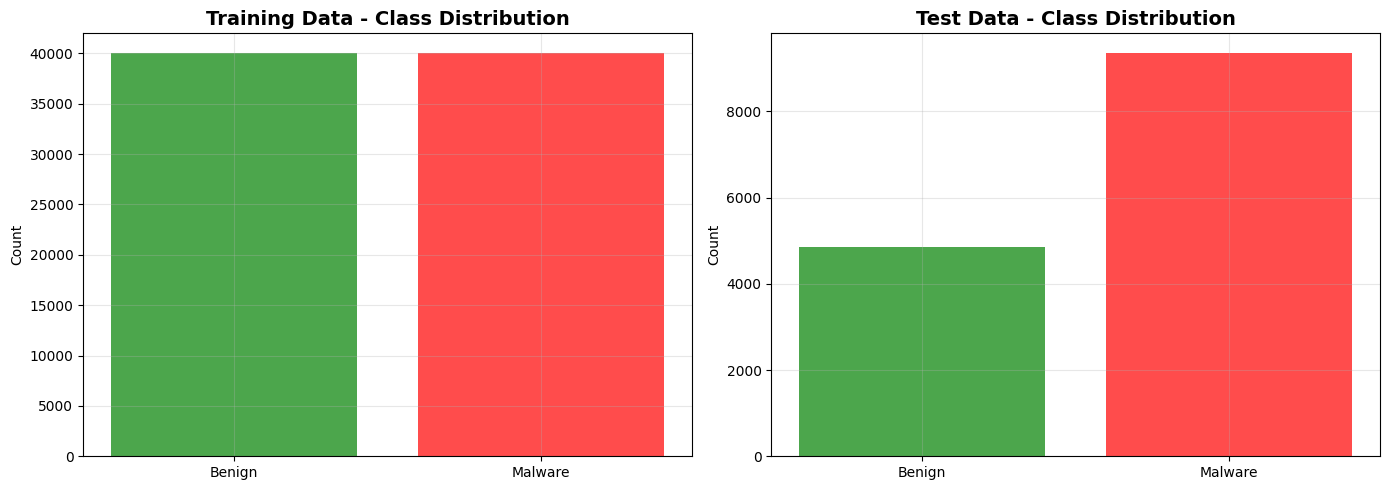


📊 Visualization saved to class_distribution.png


In [17]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Class distribution
train_counts = np.bincount(y_train_balanced.astype(int))
test_counts = np.bincount(y_test_final.astype(int))

axes[0].bar(['Benign', 'Malware'], train_counts, color=['green', 'red'], alpha=0.7)
axes[0].set_title('Training Data - Class Distribution', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Count')
axes[0].grid(True, alpha=0.3)

axes[1].bar(['Benign', 'Malware'], test_counts, color=['green', 'red'], alpha=0.7)
axes[1].set_title('Test Data - Class Distribution', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Count')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(Path(CLEANED_DATA_PATH) / 'class_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n📊 Visualization saved to class_distribution.png")